# Using `ddipp` with `fastai v1` Notebooks
## Introduction

`Ddip` is a collection of line and cell magics for iPython and Jupyter notebook.  It uses `ipyparallel` to manage PyTorch's Distributed Data Parallel (DDP) process group as a cluster.  It manages the execution of cells between the local process (the interactive notebook) and the remote DDP process group, and streams/display the outputs.

`Ddip` treats `fastai` as a client application that uses the PyTorch DDP (currently `fastai_v1` is the default application), and is designed to minimize changes to existing `fastai` course lesson notebooks, and without requiring any change to the fastai codebase itself.

If you'are unfamiliar with iPython line/cell magics: they are commands prefixed with `%` or `%%`, to control/customize/extend the behavior of the iPython/Jupyter notebook.

Let's try it on a barebone version of the `fastai` lesson3-CamVid notebook. The original version is here: [lesson3-Camvid.ipynb](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson3-camvid.ipynb)

## Image segmentation with CamVid

**Load extension with `%load_ext Ddip`, and create a DDP group with `%makedip`.**

Creating the DDP group now, so that we can start loading up things into the DDP process namespace.  See the next cell where `fastai` libraries are imported to both namespaces.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

%load_ext Ddip
%makedip -g all -a fastai_v1 --verbose False

Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-ippdpp_c-client.json


**Load python libraries needed for data exploration, and later for training**

In [2]:
%%dip everywhere
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
import os

**Explore the raw data locally in notebook process**

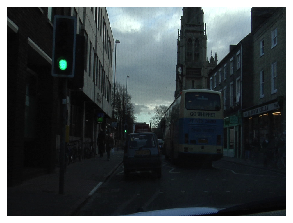

In [3]:
path = untar_data(URLs.CAMVID)
path_lbl = path/'labels'
path_img = path/'images'
fnames = get_image_files(path_img)
lbl_names = get_image_files(path_lbl)
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

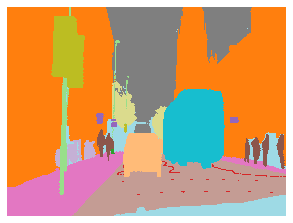

In [4]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

... Perform data cleaning and massages in local notebook process as necessary, until about time to create the *training dataset*

In [5]:
src_size = np.array(mask.shape[1:])
codes = np.loadtxt(path/'codes.txt', dtype=str)
size = src_size//2
bs=8
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

**Create training dataset on remote DDP processes**

All DDP processes (one per GPU) needs to access the training dataset.  Let's send over all the necessary ingridients -- variables/objects prepared above -- using `%dipush var1 var2 ... varN`, then whip up the dataset.

Then we can start cooking in the DDP multiprocess pool, with `%autodip on`

In [6]:
%dipush bs size get_transforms src src_size path path_lbl path_img codes get_y_fn
%autodip on

Auto Execution on DDP group: on, will run cell as %%dip



**With `%autodip` set to `on`, all cells below will be executed on the DDP processes, not the local notebook namespace.  The exception is when the cell starts with any `%` or `%%` line/cell magic, it is interpreted first by the local iPython.**

Below, `%%dip` is implied due to `%autodip on` and the cell is run on ALL remote processes.  By default, only rank-0 process output is displayed.  To see output from all processes, start the cell with `%%dip --see all`

Let us verify a PUSH'ed variable, and Create a new one.

In [7]:
print(f"Remote process [{os.getpid()}]: bs is {bs}, size is {size}")
name2id = {v:k for k,v in enumerate(codes)}
print(f"Remote process [{os.getpid()}]: freshly created name2vid['Void']", name2id['Void'])

Remote process [10945]: bs is 8, size is [360 480]
Remote process [10945]: freshly created name2vid['Void'] 30


**Is `name2vid` visible in the local space?**  Let's verify that with `%%dip local`.

Since the first line begins with a `%`, it overrides the interception by `%autodip on`.

In [8]:
%%dip local
print(f"Local process [{os.getpid()}]:", name2id['Void'])

NameError: name 'name2id' is not defined

**Need to use `name2vid` in local notebook space later?**

`%dipull X` will pull the object `X` into the local notebook namespace.

In [9]:
%dipull name2id

# Now try again:
print(f"Local process [{os.getpid()}]:", name2id['Void'])

Local process [10891]: 30


epoch     train_loss  valid_loss  acc_camvid  time    
0         12.955206   #na#        00:48                                                   
1         125.922951  #na#        00:02       -------| 1.33% [1/75 00:01<02:11 13.0127]
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


[output:0]

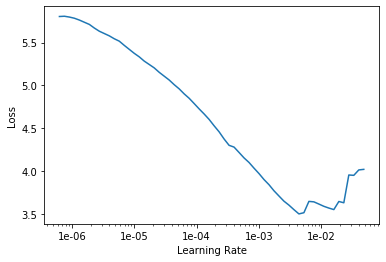

In [10]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

metrics=acc_camvid
wd=1e-2
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)
# lr_find(learn)
learn.lr_find()
learn.recorder.plot()

In [11]:
lr=3e-3
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch     train_loss  valid_loss  acc_camvid  time    
0         2.217546    1.287429    0.706502    00:30                                       
1         1.531108    0.886328    0.778832    00:20                                       
2         1.186182    0.702652    0.827826    00:20                                       
3         0.975255    0.595218    0.842702    00:20                                       
4         0.835104    0.528546    0.859509    00:20                                       
5         1.838303    2.342685    0.184562    00:20                                       
6         1.908939    1.800216    0.556397    00:20                                       
7         1.724544    1.317294    0.671205    00:20                                       
8         1.583164    1.273683    0.631114    00:20                                       
9         1.403603    1.126628    0.667433    00:20                                        


## Speedup observed

   Notebook       [3-GPUs timing]  [Single-GPU timing]          LOC
* lesson3-CamVid: [3:30,4:24,12:00,12:52] [7:33,9:12,31:50,33:40]    6
* lesson3-planet: [3:20,3:45,6:15,7:30]   [4:20,5:35,14:35,18:30]    4
* lesson4-collab: Training time too short
* lesson4-tabular: Training time too short, but conversion is simple, only 1 cell, 3 lines.
* lesson5-sgd-mnist: Training time too short
* lesson6-pets-more: [1:06, 0:48,1:30,]      [1:09, 0:48, 1:30]
* lesson6-rossmann: [1:45,1:45,1:45]        [3:00,      4]

